# Customer Segmentaton of Retail Data


### Problem Statement

It is a critical requirement for business to understand the value derived from a customer. RFM is a method used for analyzing customer value.

Customer segmentation is the practice of segregating the customer base into groups of individuals based on some common characteristics such as age, gender, interests, and spending habits.

Our objective here is to perform customer segmentation using RFM analysis. The resulting segments can be ordered from most valuable (highest recency, frequency, and value) to least valuable (lowest recency, frequency, and value).


In [ ]:
__author__ = "Ovo Okpubuluku"
__email__ = "ovo@live.ca"

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

## Now we create a Data Class to ingest the data and show us some summary statistics

In [10]:
class Data:
    def __init__(self, dataset):
        
        '''loading dataframes'''
        
        self.dataset = dataset
        self.process_data()
        
    def process_data(self):
        self._create_df()
        self._column_info()
        self._print_df_stats()
        self._check_duplicates()
       
    def _create_df(self):
        '''loads and prepares dataframe'''
        self.df = self._load_dataset(dataset)        
        
    def _column_info(self):
        self.cat_cols = self._cat_cols(self.df)
        self.num_cols = self._num_cols(self.df)
        
    def _print_df_stats(self):
        print('  \n ----------Train Data Info---------')
        self.printstats(self.df)
        self._check_nan(self.df)
    
    def _load_dataset(self, file):
        return pd.read_excel(file)
    
    def printstats(self, df):
        print('---------------------------------------------------------')
        print('Shape of Dataframe - {}'.format(df.shape))
        print('---------------------------------------------------------')
        print('\n Dataframe Info: \n')
        print('n{}'.format(df.info()))
        print('---------------------------------------------------------')
        print(' Categorical Features Stats: \n \n{}'.format(df.describe(include='O')))
        print('-------------------------------------------------')
        print(' Numerical Features Stats:- \n \n{}'.format(df.describe()))
              
    def _check_nan(self, df):
        '''Checks and verifies presence of null values in Dataframe'''
        nan = np.sum(df.isna().sum())
        if nan == 0:
            print('\n\n : There are no null values in the dataframes')
        else:
            print('The following columns have null values\n\n{}'.format(df.isnull().sum()))
              
    def _cat_cols(self, df):
        '''finds and lists Categorical Columns in Dataframe'''
        self.cat_cols = df.select_dtypes(include=['O']).columns.tolist()
        print('Categorical Columns list: {}'.format(self.cat_cols))
        print('---------------------------------------------------------------------')
        return self.cat_cols
              
    def _num_cols(self, df):
        '''finds and lists Numerical Columns in Dataframe'''
        self.num_cols = df.select_dtypes(exclude=['O']).columns.tolist()
        print('Numerical Columns list: {}'.format(self.num_cols))
        print('---------------------------------------------------------------------')
        return self.num_cols
              
             
    def _check_duplicates(self):
        '''Checks presence of duplicate entries'''
        print('\n : There are {} duplicate values in the Dataframe'.format(self.df.duplicated().sum()))

In [11]:
dataset = "./online_retail.xlsx"

In [12]:
data = Data(dataset)

Categorical Columns list: ['InvoiceNo', 'StockCode', 'Description', 'Country']
---------------------------------------------------------------------
Numerical Columns list: ['Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID']
---------------------------------------------------------------------
  
 ----------Train Data Info---------
---------------------------------------------------------
Shape of Dataframe - (541909, 8)
---------------------------------------------------------

 Dataframe Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null 

In [13]:
data.df.Quantity[data.df.Quantity < 0].count()

10624

In [14]:
data.df.UnitPrice[data.df.UnitPrice < 0].count()

2

In [15]:
data.df['CustomerID'].nunique()

4372

In [16]:
print('The first order date in the data is: ')
print(data.df['InvoiceDate'].min())

print('The last order date in the data is: ')
print(data.df['InvoiceDate'].max())

The first order date in the data is: 
2010-12-01 08:26:00
The last order date in the data is: 
2011-12-09 12:50:00


In [17]:
print(data.df.shape)
data.df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Handling null values, Duplicate values, and Unrealistic values from Dataframe

1. We notice from the information above that we have 135080 null values for customerID. We will have to remove all the entries without customerID because we cannot perform segmentation and cohort analysis on Customers that we cannot identify.

2. The 'Quantity' and 'UnitPrice' features have negative numbers. We will have to remove these numbers, as they are not realistic. They are probably returns or reversed transactions that were not concluded.


3. We also notice that we have 1454 null values for Description. This column has no real effect on the data, and we may end up removing it altogether.

4. We can see here that there are 4372 Unique Customers in this dataset.


5. Finally, we notice the presence of 5268 duplicate entries, and we have to remove those, to avoid distorting the model

In [18]:
data.df.dropna(inplace=True)
print('Null Values after handling:') 
data.df.isnull().sum()

Null Values after handling:


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [19]:
data.df.drop_duplicates(subset=None, keep='first', inplace=True)
data.df.duplicated().sum()

0

In [20]:
data.df = data.df[data.df['Quantity'] > 0]
print(data.df['Quantity'].min())
data.df = data.df[data.df['UnitPrice'] > 0]
print(data.df['UnitPrice'].min())

1
0.001


In [21]:
data.df.shape

(392692, 8)

In [22]:
total_orders = data.df.groupby(['CustomerID'])['InvoiceNo'].nunique()
multiple_orders = np.sum(total_orders > 1) / data.df['CustomerID'].nunique()
print(f'{100 * multiple_orders:.2f}% of customers ordered more than once.')

65.58% of customers ordered more than once.


In [23]:
data.df['TotalPrice'] = data.df['Quantity'] * data.df['UnitPrice']
data.df.head()

#Get rid of irrelevant features in the dataset
retail_data = data.df.loc[:, ['Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice']]
retail_data.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Cohort Analysis

In [58]:
#Define functions to extract month and day

def get_month(x):
    return dt.datetime(x.year, x.month, 1)

def get_day(x):
    return dt.datetime(x.year, x.month, x.day, 1)

def get_date(df, month_column, day_column):
    '''extracting year, month and day integer values'''
    year = df[month_column].dt.year
    month = df[month_column].dt.month
    day = df[day_column].dt.day
    return year, month, day

In [59]:
#Assigning for monthly acquisition cohorts
retail_data['InvoiceMonth'] = retail_data['InvoiceDate'].apply(get_month)
month_grouping = retail_data.groupby('CustomerID')['InvoiceMonth']
retail_data['CohortMonth'] = month_grouping.transform('min')

#Assigning for daily acquisition cohorts
retail_data['InvoiceDay'] = retail_data['InvoiceDate'].apply(get_day)
day_grouping = retail_data.groupby('CustomerID')['InvoiceDay']
retail_data['CohortDay'] = day_grouping.transform('min')

retail_data.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth,InvoiceDay,CohortDay,IndexMonths,IndexDays
0,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1
1,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1
2,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1
3,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1
4,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1


### Assigning time offset in months and days

In [60]:
invoice_year, invoice_month, invoice_day = get_date(retail_data, 'InvoiceMonth', 'InvoiceDay')
cohort_year, cohort_month, cohort_day = get_date(retail_data, 'CohortMonth', 'CohortDay')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
days_diff = invoice_day - cohort_day

retail_data['IndexMonths'] = years_diff * 12 + months_diff + 1
retail_data['IndexDays'] = years_diff * 365 + months_diff * 30 + days_diff + 1

retail_data.head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth,InvoiceDay,CohortDay,IndexMonths,IndexDays
0,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1
1,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1
2,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1
3,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1
4,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01,2010-12-01 01:00:00,2010-12-01 01:00:00,1,1


### Counting Monthly active customers from each Cohort

In [61]:
month_group = retail_data.groupby(['CohortMonth', 'IndexMonths'])
cohort_data_month = month_group['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts_mnth = cohort_data_month.pivot(index='CohortMonth',
                                            columns='IndexMonths',
                                            values='CustomerID')

cohort_counts_mnth.head(20)

IndexMonths,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Daily active customers from each Cohort

In [62]:
day_group = retail_data.groupby(['CohortDay', 'IndexDays'])
cohort_data_days = day_group['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_counts_days = cohort_data_days.pivot(index='CohortDay',
                                            columns='IndexDays',
                                            values='CustomerID')

print(cohort_counts_days.shape)
cohort_counts_days.head()

(305, 374)


IndexDays,1,2,3,4,5,6,7,8,9,10,...,365,366,367,368,369,370,371,372,373,374
CohortDay,,,,,,,,,,,,,,,,,,,,,
2010-12-01 01:00:00,95.0,6.0,4.0,NaN,5.0,7.0,3.0,10.0,7.0,5.0,...,6.0,7.0,8.0,NaN,2.0,5.0,6.0,6.0,7.0,5.0
2010-12-02 01:00:00,93.0,NaN,NaN,NaN,2.0,6.0,3.0,7.0,4.0,NaN,...,6.0,4.0,NaN,NaN,4.0,2.0,4.0,3.0,2.0,NaN
2010-12-03 01:00:00,46.0,NaN,1.0,1.0,1.0,NaN,3.0,NaN,NaN,1.0,...,5.0,NaN,2.0,2.0,3.0,1.0,3.0,NaN,NaN,NaN
2010-12-05 01:00:00,69.0,2.0,3.0,1.0,4.0,1.0,NaN,6.0,7.0,2.0,...,6.0,2.0,3.0,5.0,3.0,1.0,NaN,NaN,NaN,NaN
2010-12-06 01:00:00,70.0,2.0,2.0,1.0,1.0,NaN,1.0,3.0,8.0,4.0,...,3.0,3.0,6.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN


## Calculating Cohort Metrics - Monthly & Daily

### 1. Retention Rate

In [63]:
#Monthly Retention Rates

cohort_sizes_mnth = cohort_counts_mnth.iloc[:,0]
monthly_retention = cohort_counts_mnth.divide(cohort_sizes_mnth, axis=0)
monthly_retention.round(5) * 100

IndexMonths,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.610,32.316,38.418,36.271,39.774,36.271,34.915,35.367,39.548,37.401,50.282,26.554
2011-01-01,100.0,22.062,26.619,23.022,32.134,28.777,24.700,24.221,29.976,32.614,36.451,11.751,NaN
2011-02-01,100.0,18.684,18.684,28.421,27.105,24.737,25.263,27.895,24.737,30.526,6.842,NaN,NaN
2011-03-01,100.0,15.044,25.221,19.912,22.345,16.814,26.770,23.009,27.876,8.628,NaN,NaN,NaN
2011-04-01,100.0,21.333,20.333,21.000,19.667,22.667,21.667,26.000,7.333,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.014,17.254,17.254,20.775,23.239,26.408,9.507,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.355,15.702,26.446,23.140,33.471,9.504,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.085,20.745,22.340,27.128,11.170,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.710,24.852,24.260,12.426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
#Daily Retention Rates

cohort_sizes_days = cohort_counts_days.iloc[:,0]
daily_retention = cohort_counts_days.divide(cohort_sizes_days, axis=0)
daily_retention.round(5) * 100

IndexDays,1,2,3,4,5,6,7,8,9,10,...,365,366,367,368,369,370,371,372,373,374
CohortDay,,,,,,,,,,,,,,,,,,,,,
2010-12-01 01:00:00,100.0,6.316,4.211,NaN,5.263,7.368,3.158,10.526,7.368,5.263,...,6.316,7.368,8.421,NaN,2.105,5.263,6.316,6.316,7.368,5.263
2010-12-02 01:00:00,100.0,NaN,NaN,NaN,2.151,6.452,3.226,7.527,4.301,NaN,...,6.452,4.301,NaN,NaN,4.301,2.151,4.301,3.226,2.151,NaN
2010-12-03 01:00:00,100.0,NaN,2.174,2.174,2.174,NaN,6.522,NaN,NaN,2.174,...,10.870,NaN,4.348,4.348,6.522,2.174,6.522,NaN,NaN,NaN
2010-12-05 01:00:00,100.0,2.899,4.348,1.449,5.797,1.449,NaN,8.696,10.145,2.899,...,8.696,2.899,4.348,7.246,4.348,1.449,NaN,NaN,NaN,NaN
2010-12-06 01:00:00,100.0,2.857,2.857,1.429,1.429,NaN,1.429,4.286,11.429,5.714,...,4.286,4.286,8.571,4.286,1.429,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05 01:00:00,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-06 01:00:00,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-07 01:00:00,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


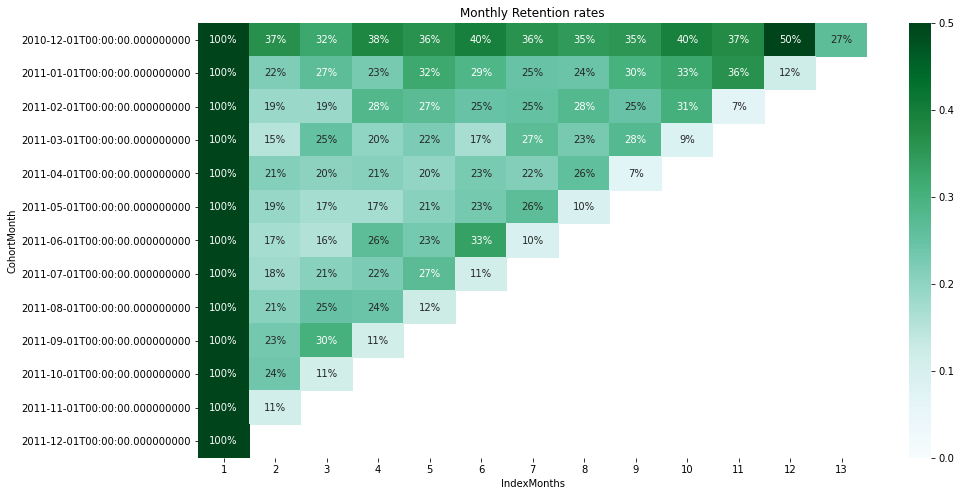

In [65]:
plt.figure(figsize=(15, 8))
plt.title('Monthly Retention rates')
sns.heatmap(data = monthly_retention,
           annot = True,
           fmt = '.0%',
           vmin = 0.0,
           vmax = 0.5,
           cmap = 'BuGn')

plt.show()

### 2. Average Quantity

In [66]:
#Monthly Average Quantity

cohort_data_month = month_group['Quantity'].mean().reset_index()
average_quantity_mnth = cohort_data_month.pivot(index='CohortMonth',
                                            columns='IndexMonths',
                                            values='Quantity')

average_quantity_mnth.round(3)

IndexMonths,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,12.117,15.670,15.726,15.931,13.625,14.923,16.113,15.638,18.207,17.700,19.047,13.600,15.383
2011-01-01,17.471,13.472,12.708,15.284,12.845,15.389,14.974,14.992,11.629,10.624,9.597,10.184,NaN
2011-02-01,11.202,13.741,19.032,12.046,12.336,12.331,13.571,13.401,10.966,12.416,13.390,NaN,NaN
2011-03-01,9.963,11.741,13.311,10.121,13.756,13.014,13.456,13.851,11.325,9.700,NaN,NaN,NaN
2011-04-01,10.044,10.418,9.773,11.870,11.963,8.692,10.001,9.678,7.567,NaN,NaN,NaN,NaN
2011-05-01,11.457,9.745,14.224,12.758,11.217,8.759,10.764,113.763,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.665,14.727,10.870,13.663,10.690,9.961,9.506,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.921,13.750,7.398,8.178,6.214,7.164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.083,6.199,5.440,6.151,7.057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
#Daily Average Quantity

cohort_data_days = day_group['Quantity'].mean().reset_index()
average_quantity_days = cohort_data_days.pivot(index='CohortDay',
                                            columns='IndexDays',
                                            values='Quantity')

average_quantity_days.round(2)

IndexDays,1,2,3,4,5,6,7,8,9,10,...,365,366,367,368,369,370,371,372,373,374
CohortDay,,,,,,,,,,,,,,,,,,,,,
2010-12-01 01:00:00,12.70,7.35,13.48,NaN,4.67,10.67,10.36,14.44,7.22,7.03,...,19.58,8.23,5.86,NaN,8.85,18.99,10.89,19.79,8.75,22.61
2010-12-02 01:00:00,16.96,NaN,NaN,NaN,63.50,21.91,13.20,12.89,45.70,NaN,...,25.63,36.15,NaN,NaN,13.15,80.44,14.64,13.86,17.67,NaN
2010-12-03 01:00:00,10.55,NaN,5.87,1.86,2.00,NaN,8.03,NaN,NaN,17.50,...,49.00,NaN,4.94,4.67,14.26,6.50,101.32,NaN,NaN,NaN
2010-12-05 01:00:00,6.43,23.56,8.05,30.00,4.00,1.79,NaN,8.83,12.69,3.00,...,4.18,27.12,6.33,7.98,15.85,18.53,NaN,NaN,NaN,NaN
2010-12-06 01:00:00,7.16,3.83,20.83,8.21,3.89,NaN,2.27,8.83,5.03,9.25,...,13.33,21.11,17.37,13.88,18.67,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05 01:00:00,8.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-06 01:00:00,10.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-07 01:00:00,37.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


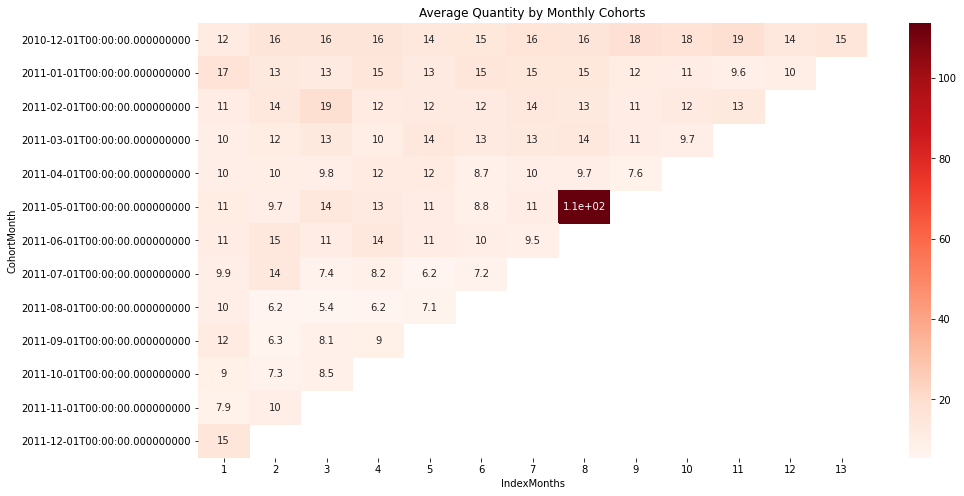

In [69]:
plt.figure(figsize=(15, 8))
plt.title('Average Quantity by Monthly Cohorts')
sns.heatmap(data = average_quantity_mnth,
           annot = True,
           cmap = 'Reds')

plt.show()

### 3. Average Price

In [33]:
#Monthly Average Price

cohort_data_month = month_group['TotalPrice'].mean().reset_index()
average_price_mnth = cohort_data_month.pivot(index='CohortMonth',
                                            columns='IndexMonths',
                                            values='TotalPrice')

average_price_mnth.round(3)

IndexMonths,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,22.221,27.271,26.860,27.189,21.192,28.136,28.338,27.431,29.251,33.465,33.993,23.635,25.841
2011-01-01,26.879,25.100,20.968,31.234,22.478,26.280,25.243,25.493,19.074,22.332,19.727,19.781,NaN
2011-02-01,17.868,20.848,21.459,19.363,17.692,16.976,22.166,22.902,18.790,22.184,23.504,NaN,NaN
2011-03-01,17.589,21.140,22.694,18.018,21.106,19.003,22.034,19.990,16.812,13.197,NaN,NaN,NaN
2011-04-01,16.953,21.029,19.493,18.737,19.548,14.999,15.252,15.967,12.343,NaN,NaN,NaN,NaN
2011-05-01,20.483,17.341,22.247,20.897,18.588,14.116,17.018,234.534,NaN,NaN,NaN,NaN,NaN
2011-06-01,23.984,16.286,19.950,20.449,15.345,16.712,13.220,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,14.958,23.532,11.787,13.018,10.885,11.684,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,16.522,13.158,12.525,15.883,17.002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
#Daily Average Price

cohort_data_days = day_group['TotalPrice'].mean().reset_index()
average_price_days = cohort_data_days.pivot(index='CohortDay',
                                            columns='IndexDays',
                                            values='TotalPrice')

average_price_days.round(3)

IndexDays,1,2,3,4,5,6,7,8,9,10,...,365,366,367,368,369,370,371,372,373,374
CohortDay,,,,,,,,,,,,,,,,,,,,,
2010-12-01,24.337,21.702,32.444,NaN,9.703,25.110,19.885,20.608,21.254,13.288,...,32.631,14.338,12.774,NaN,12.590,15.526,15.695,35.105,19.197,29.272
2010-12-02,24.401,NaN,NaN,NaN,113.193,41.614,22.031,34.999,108.564,NaN,...,61.389,59.738,NaN,NaN,23.879,222.148,25.272,20.255,38.652,NaN
2010-12-03,20.723,NaN,9.206,3.857,19.900,NaN,18.879,NaN,NaN,194.325,...,82.794,NaN,7.058,5.917,28.374,11.556,83.663,NaN,NaN,NaN
2010-12-05,12.362,59.754,24.328,63.000,11.358,4.020,NaN,14.714,23.557,8.921,...,8.044,54.689,16.038,22.850,47.960,14.749,NaN,NaN,NaN,NaN
2010-12-06,12.980,26.142,33.463,14.295,8.249,NaN,5.790,19.947,9.589,19.656,...,16.241,21.035,19.537,28.171,138.533,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-05,6.627,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-06,10.616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-07,89.743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


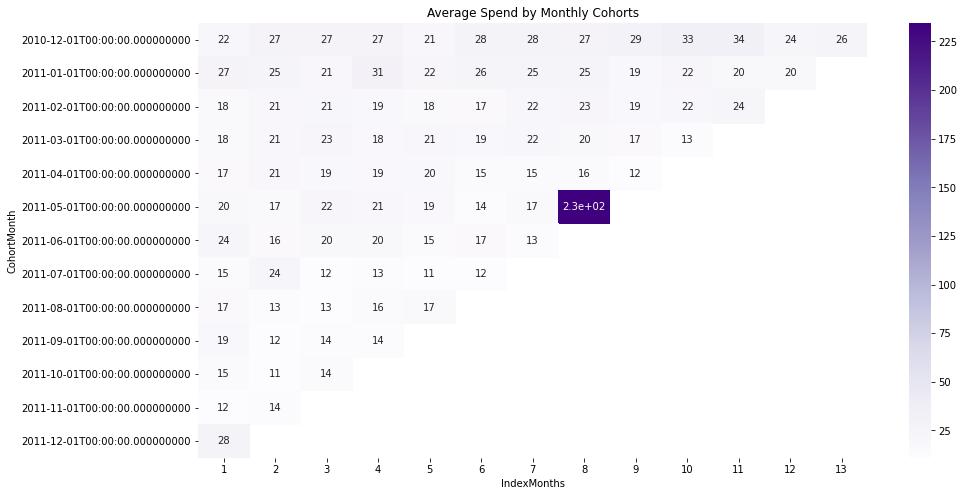

In [72]:
plt.figure(figsize=(15, 8))
plt.title('Average Spend by Monthly Cohorts')
sns.heatmap(data = average_price_mnth,
           annot = True,
           cmap = 'Purples')

plt.show()